In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
from PIL import Image
from tqdm import tqdm

In [ ]:
@jit(nopython=True, parallel=True)
def step(u, u_prev, c, dt, dx, dy, nx, ny):
    u_next = np.zeros_like(u)
    coeff_x = (c * dt / dx)**2
    coeff_y = (c * dt / dy)**2

    for i in prange(1, ny - 1):
        for j in range(1, nx - 1):
            for k in range(3): 
                u_next[i, j, k] = (
                    2 * u[i, j, k]
                    - u_prev[i, j, k]
                    + coeff_x * (u[i + 1, j, k] + u[i - 1, j, k] - 2 * u[i, j, k])
                    + coeff_y * (u[i, j + 1, k] + u[i, j - 1, k] - 2 * u[i, j, k])
                )
    return np.clip(u_next, 0, 1)

def solve_wave_vector(image_path, c, dt, dx, dy, T, save_interval=10):
    image = Image.open(image_path).convert("RGB")
    u = np.array(image, dtype=np.float64) / 255.0
    u_prev = u.copy()
    frames = int(T / dt)
    ny, nx, _ = u.shape
    for n in tqdm(range(frames)):
        u_next = step(u, u_prev, c, dt, dx, dy, nx, ny)
        u_prev, u = u, u_next
        if n % save_interval == 0:
            fig = plt.figure(figsize=(nx / dpi, ny / dpi), dpi=dpi)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.imshow(u, aspect='auto')
            ax.axis("off") 
            plt.savefig(f"images/frame-{int(n*dt):04d}.png", dpi=dpi, bbox_inches='tight', pad_inches=0, transparent=True)
            plt.close(fig)

# Parameters
dx = dy = 0.1
dt = 0.1
c = 0.01
T = 2000
image_path = "thebeatles.jpg"
dpi=72

# Solve the wave equation
solve_wave_vector(image_path, c, dt, dx, dy, T)


 50%|█████     | 10040/20000 [42:21<42:01,  3.95it/s]  


  2%|▏         | 350/20000 [01:22<1:17:15,  4.24it/s]


KeyboardInterrupt: 

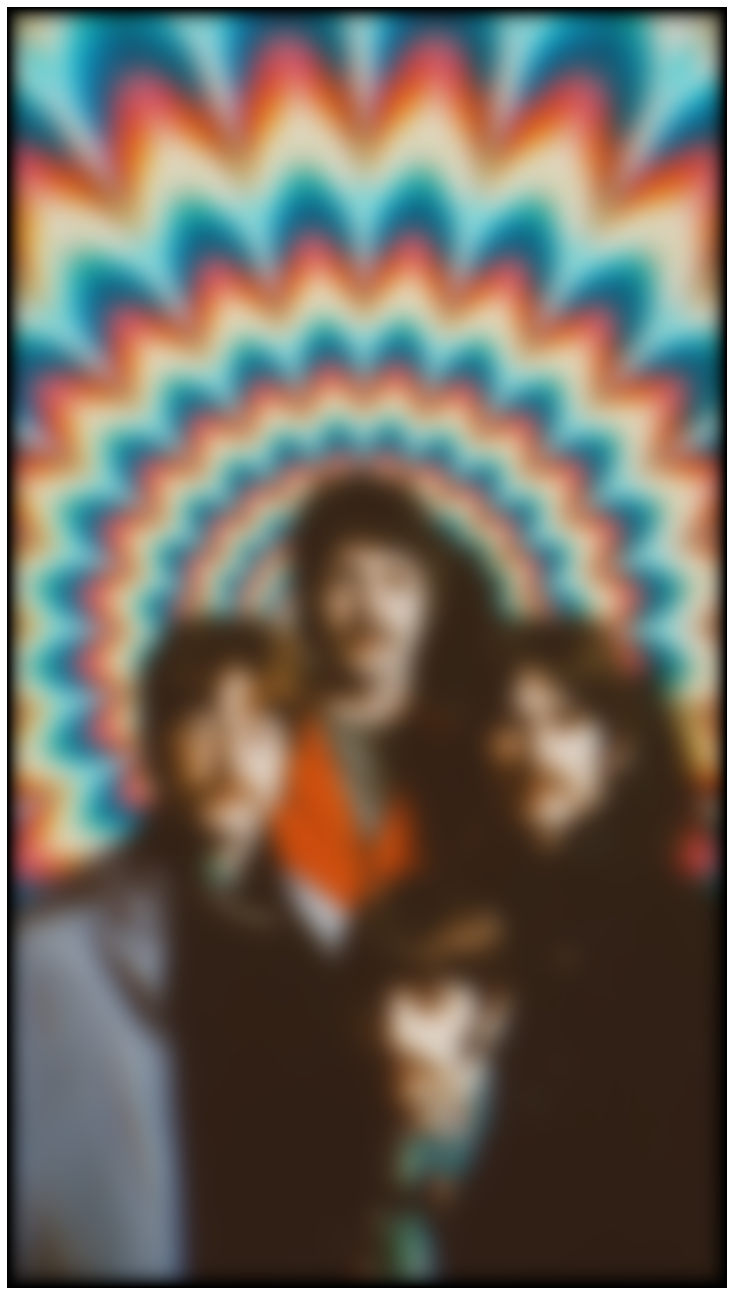

In [ ]:
@jit(nopython=True, parallel=True)
def step_heat(u, alpha, dt, dx, dy, nx, ny):
    u_next = np.zeros_like(u)
    coeff_x = alpha * dt / dx**2
    coeff_y = alpha * dt / dy**2

    for i in prange(1, ny - 1):
        for j in range(1, nx - 1):
            for k in range(3):  # RGB channels
                u_next[i, j, k] = (
                    u[i, j, k]
                    + coeff_x * (u[i + 1, j, k] + u[i - 1, j, k] - 2 * u[i, j, k])
                    + coeff_y * (u[i, j + 1, k] + u[i, j - 1, k] - 2 * u[i, j, k])
                )
    return np.clip(u_next, 0, 1)

def solve_heat_equation(image_path, alpha, dt, dx, dy, T, save_interval=10):
    image = Image.open(image_path).convert("RGB")
    u = np.array(image, dtype=np.float64) / 255.0
    ny, nx, _ = u.shape
    frames = int(T / dt)

    for n in tqdm(range(frames)):
        u = step_heat(u, alpha, dt, dx, dy, nx, ny)
        
        if n % save_interval == 0:
            fig = plt.figure(figsize=(nx / dpi, ny / dpi), dpi=dpi)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.imshow(u, aspect='auto')
            ax.axis("off")
            plt.savefig(f"images/frame-{int(n*dt):04d}.png", dpi=dpi, bbox_inches='tight', pad_inches=0, transparent=True)
            plt.close(fig)

# Parameters
dx = dy = 0.1
dt = 0.1
alpha = 0.02  # Thermal diffusivity
T = 2000
image_path = "thebeatles.jpg"
dpi = 72

# Solve the heat equation
solve_heat_equation(image_path, alpha, dt, dx, dy, T)


In [8]:
@jit(nopython=True, parallel=True)
def step_prey_predator(u, D, r, alpha, f, q, dt, dx, dy, nx, ny):
    u_next = np.zeros_like(u)
    coeff_x = D * dt / dx**2
    coeff_y = D * dt / dy**2
    
    for i in prange(1, ny - 1):
        for j in range(1, nx - 1):
            laplacian = (
                (u[i + 1, j] + u[i - 1, j] - 2 * u[i, j]) / dx**2 +
                (u[i, j + 1] + u[i, j - 1] - 2 * u[i, j]) / dy**2
            )
            
            R, N, P = u[i, j]
            
            dRdt = r * R - alpha * N * R
            dNdt = f * alpha * N * R - q * N
            dPdt = D * laplacian[2]  # Only diffusion for P
            
            u_next[i, j, 0] = R + dt * (D * laplacian[0] + dRdt)
            u_next[i, j, 1] = N + dt * (D * laplacian[1] + dNdt)
            u_next[i, j, 2] = P + dt * dPdt  # Only diffusion for P
    
    return np.clip(u_next, 0, 1)

def solve_prey_predator(image_path, D, r, alpha, f, q, dt, dx, dy, T, save_interval=10):
    image = Image.open(image_path).convert("RGB")
    u = np.array(image, dtype=np.float64) / 255.0
    ny, nx, _ = u.shape
    frames = int(T / dt)
    
    # Adjust parameters for oscillatory behavior
    r *= 1.2
    alpha *= 0.8
    f *= 1.1
    q *= 0.9

    for n in tqdm(range(frames)):
        u = step_prey_predator(u, D, r, alpha, f, q, dt, dx, dy, nx, ny)
        
        if n % save_interval == 0:
            fig = plt.figure(figsize=(nx / dpi, ny / dpi), dpi=dpi)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.imshow(u, aspect='auto')
            ax.axis("off")
            plt.savefig(f"images/frame-{int(n*dt):04d}.png", dpi=dpi, bbox_inches='tight', pad_inches=0, transparent=True)
            plt.close(fig)

# Parameters
dx = dy = 0.1
dt = 0.1
D = 0.02  # Diffusion coefficient
r = 0.1   # Growth rate of basal prey
alpha = 0.02  # Attack rate of N on R
f = 0.1  # Conversion efficiency of R to new N
q = 0.02  # Decline rate of N in absence of prey
T = 2000
image_path = "thebeatles.jpg"
dpi = 72

solve_prey_predator(image_path, D, r, alpha, f, q, dt, dx, dy, T)


  2%|▏         | 306/20000 [01:55<2:03:26,  2.66it/s]


KeyboardInterrupt: 